# Naive Bayes Classification - Customer Loyalty Dataset (Lengkap dengan ROC Curve)

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import  files
uploaded= files.upload()

Saving Customer Purchasing Behaviors.csv to Customer Purchasing Behaviors (2).csv


In [ ]:
# prompt: MISSING values

df = pd.read_csv('Customer Purchasing Behaviors.csv') # Assuming the uploaded file is named 'customer_loyalty.csv'

# Check for missing values
print("Missing values before handling:")
print(df.isnull().sum())

# Example: Impute missing values in numerical columns with the median
for col in df.select_dtypes(include=np.number).columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

# Example: Impute missing values in categorical columns with the mode
for col in df.select_dtypes(include='object').columns:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)

print("\nMissing values after handling:")
print(df.isnull().sum())


Missing values before handling:
user_id               0
age                   0
annual_income         0
purchase_amount       0
loyalty_score         0
region                0
purchase_frequency    0
dtype: int64

Missing values after handling:
user_id               0
age                   0
annual_income         0
purchase_amount       0
loyalty_score         0
region                0
purchase_frequency    0
dtype: int64


In [ ]:
# prompt: normalization

# Normalize numerical features
numerical_cols = df.select_dtypes(include=np.number).columns
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("\nData after normalization:")
print(df.head())


Data after normalization:
    user_id       age  annual_income  purchase_amount  loyalty_score region  \
0 -1.724789 -1.465632      -1.090306        -1.614441      -1.210582  North   
1 -1.710233 -0.501151      -0.211563        -0.541153       0.108642  South   
2 -1.695678  0.677658       0.667180         0.532134       0.636332   West   
3 -1.681123 -1.787125      -2.408420        -1.972203      -2.002117   East   
4 -1.666568 -1.036974      -0.914557        -1.471336      -1.052275  North   

   purchase_frequency  
0           -1.712679  
1           -0.394950  
2            0.483536  
3           -2.151922  
4           -1.493057  


In [ ]:
# Load Dataset
data = pd.read_csv("Customer Purchasing Behaviors.csv")


In [ ]:
df = df.drop('user_id', axis=1)

In [ ]:
df.head()

,age,annual_income,purchase_amount,loyalty_score,region,purchase_frequency
0,-1.465632,-1.090306,-1.614441,-1.210582,North,-1.712679
1,-0.501151,-0.211563,-0.541153,0.108642,South,-0.394950
2,0.677658,0.667180,0.532134,0.636332,West,0.483536
3,-1.787125,-2.408420,-1.972203,-2.002117,East,-2.151922
4,-1.036974,-0.914557,-1.471336,-1.052275,North,-1.493057


In [ ]:
# Convert loyalty_score into 3 categories
def kategori_loyalitas(score):
    if score >= 8.0:
        return 2  # Loyal
    elif score >= 6.0:
        return 1  # Biasa
    else:
        return 0  # Berisiko

data['Loyalitas'] = data['loyalty_score'].apply(kategori_loyalitas)
print("Distribusi kelas:")
print(data['Loyalitas'].value_counts())

Distribusi kelas:
Loyalitas
2    83
1    79
0    76
Name: count, dtype: int64


In [ ]:
# One-hot encoding for 'region'
data_encoded = pd.get_dummies(data, columns=['region'], drop_first=True)

In [ ]:
# Select features
features = ['age', 'annual_income', 'purchase_amount', 'purchase_frequency',
            'region_North', 'region_South', 'region_West']
X = data_encoded[features]
y = data_encoded['Loyalitas']

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Train Naive Bayes
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

GaussianNB()

In [ ]:
# Predict
y_pred = model_nb.predict(X_test)

# Evaluation
print("Akurasi:", round(accuracy_score(y_test, y_pred), 2))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Berisiko', 'Biasa', 'Loyal']))

Akurasi: 0.92

Confusion Matrix:
[[13  2  0]
 [ 0 16  0]
 [ 0  2 15]]

Classification Report:
              precision    recall  f1-score   support

    Berisiko       1.00      0.87      0.93        15
       Biasa       0.80      1.00      0.89        16
       Loyal       1.00      0.88      0.94        17

    accuracy                           0.92        48
   macro avg       0.93      0.92      0.92        48
weighted avg       0.93      0.92      0.92        48



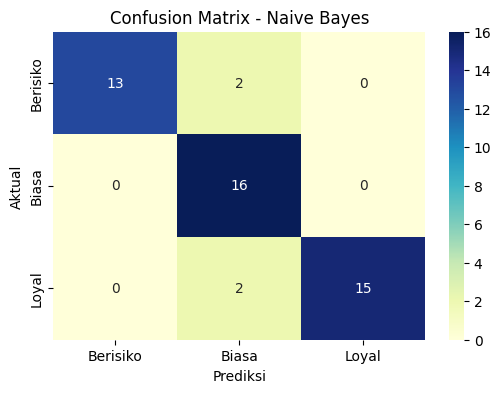

In [ ]:
# Confusion Matrix Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Berisiko', 'Biasa', 'Loyal'],
            yticklabels=['Berisiko', 'Biasa', 'Loyal'])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

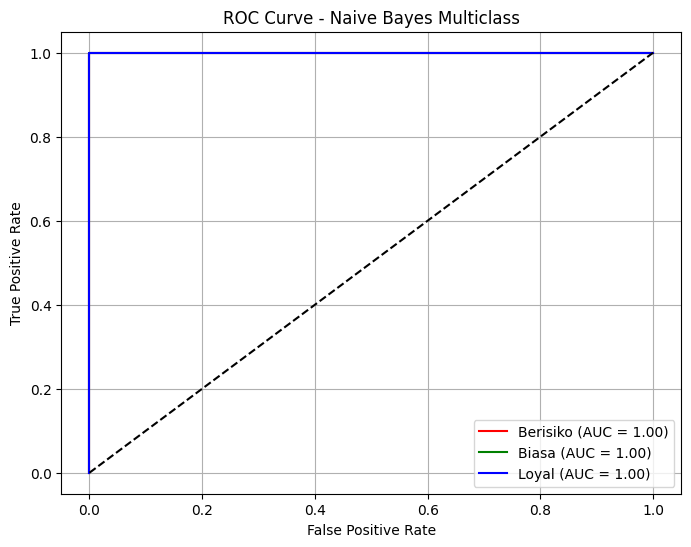

In [ ]:
# ROC Curve (multiclass, one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = model_nb.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

# Plot ROC Curve
plt.figure(figsize=(8,6))
colors = ['red', 'green', 'blue']
labels = ['Berisiko', 'Biasa', 'Loyal']

for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f"{labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve - Naive Bayes Multiclass")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# **DECISSION TREE**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score



# **ANN**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Import necessary libraries for ANN
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_cat)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2)) # Tambahkan dropout dengan rate 20%
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2)) # Tambahkan dropout dengan rate 20%
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.2933 - loss: 1.2981 - val_accuracy: 0.1579 - val_loss: 1.2351
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3719 - loss: 1.1782 - val_accuracy: 0.3158 - val_loss: 1.1690
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3352 - loss: 1.1546 - val_accuracy: 0.3158 - val_loss: 1.1187
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4175 - loss: 1.0701 - val_accuracy: 0.3158 - val_loss: 1.0782
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4125 - loss: 1.0697 - val_accuracy: 0.3158 - val_loss: 1.0398
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4725 - loss: 1.0288 - val_accuracy: 0.5263 - val_loss: 1.0047
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5526 - loss: 0.9768 - val_accuracy: 0.5789 - val_loss: 0.9680
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5075 - loss: 0.9891 - val_accuracy: 0.6842 - v

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [ ]:
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Berisiko', 'Biasa', 'Loyal']))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

Classification Report:
               precision    recall  f1-score   support

    Berisiko       1.00      1.00      1.00        15
       Biasa       1.00      1.00      1.00        16
       Loyal       1.00      1.00      1.00        17

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48

Confusion Matrix:
 [[15  0  0]
 [ 0 16  0]
 [ 0  0 17]]


In [ ]:
y_all_pred = np.argmax(model.predict(scaler.transform(X)), axis=1)
df['segment_pred_ann'] = le.inverse_transform(y_all_pred)
df[['segment_pred_ann']].head()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,segment_pred_ann
0,0
1,1
2,2
3,0
4,0


# **Linear regression**

In [ ]:
# Import Library
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [ ]:
df = pd.read_csv('Customer Purchasing Behaviors.csv')
df

,user_id,age,annual_income,purchase_amount,loyalty_score,region,purchase_frequency
0,1,25,45000,200,4.5,North,12
1,2,34,55000,350,7.0,South,18
2,3,45,65000,500,8.0,West,22
3,4,22,30000,150,3.0,East,10
4,5,29,47000,220,4.8,North,13
...,...,...,...,...,...,...,...
233,234,40,60000,450,7.2,West,20
234,235,38,59000,430,6.9,North,20
235,236,54,74000,630,9.4,South,27
236,237,32,52000,360,5.8,West,18


In [ ]:
# prompt: Using dataframe df: hilangkan kolom user_id

# Dropping the 'user_id' column from the dataframe
df = df.drop('user_id', axis=1)

In [ ]:
df.head()

,age,annual_income,purchase_amount,loyalty_score,region,purchase_frequency
0,25,45000,200,4.5,North,12
1,34,55000,350,7.0,South,18
2,45,65000,500,8.0,West,22
3,22,30000,150,3.0,East,10
4,29,47000,220,4.8,North,13


In [ ]:
# prompt: numerical_features = ["year", "km_driven", "ex_showroom_price", "selling_price"]
# df[numerical_features].corr()
# cocokkan dengan target dan fitur saya

numerical_features = ["age", "annual_income", "purchase_amount", "purchase_frequency", "loyalty_score"]
df[numerical_features].corr()['loyalty_score'].sort_values(ascending=False)

,loyalty_score
loyalty_score,1.000000
purchase_amount,0.994147
purchase_frequency,0.986990
annual_income,0.984351
age,0.981835


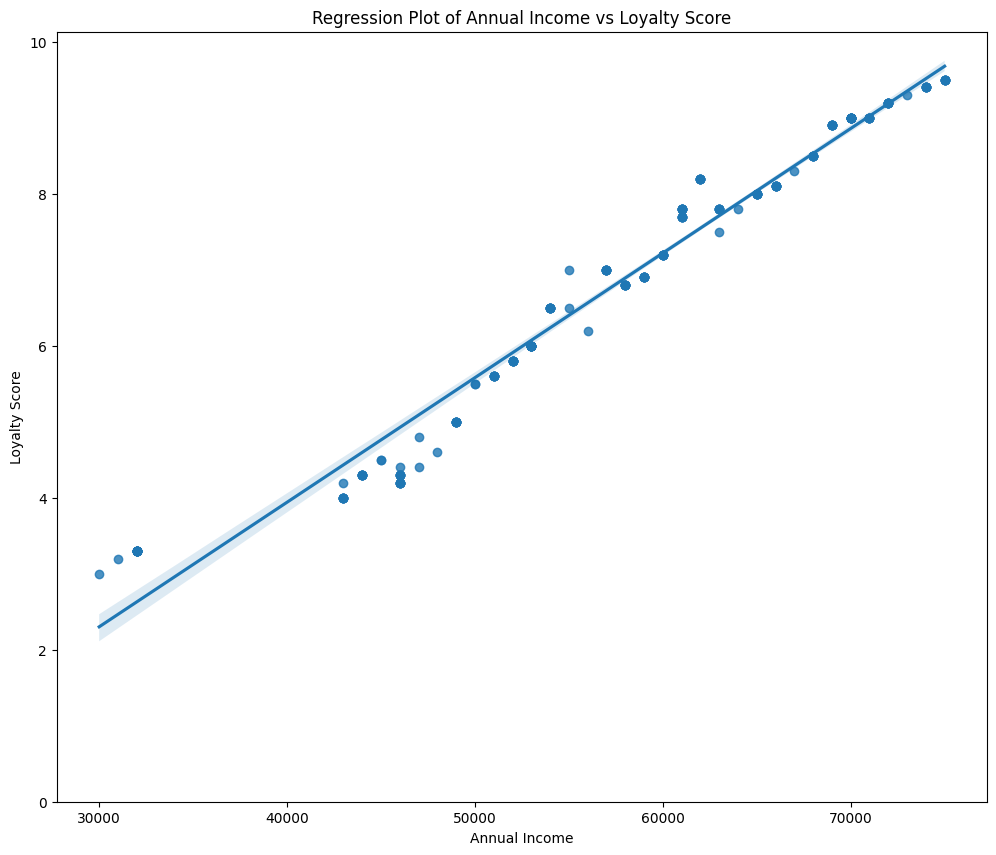

In [ ]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns # Corrected import alias

# ... (rest of your code for plotting)

width = 12
height = 10
plt.figure(figsize=(width, height))
# Using 'annual_income' and 'loyalty_score' which are in the final 'df' of the provided code
sns.regplot(x="annual_income", y="loyalty_score", data=df) # Used the correct alias 'sns'
plt.ylim(0,)
plt.title('Regression Plot of Annual Income vs Loyalty Score')
plt.xlabel('Annual Income')
plt.ylabel('Loyalty Score')
plt.show()

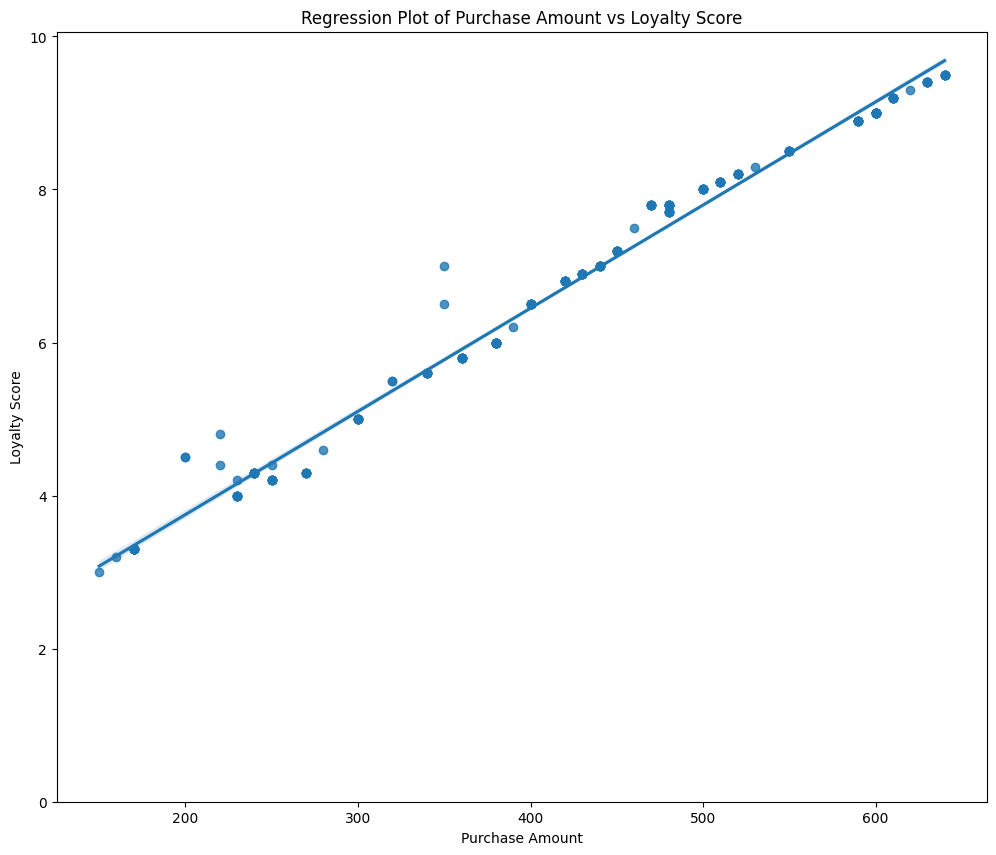

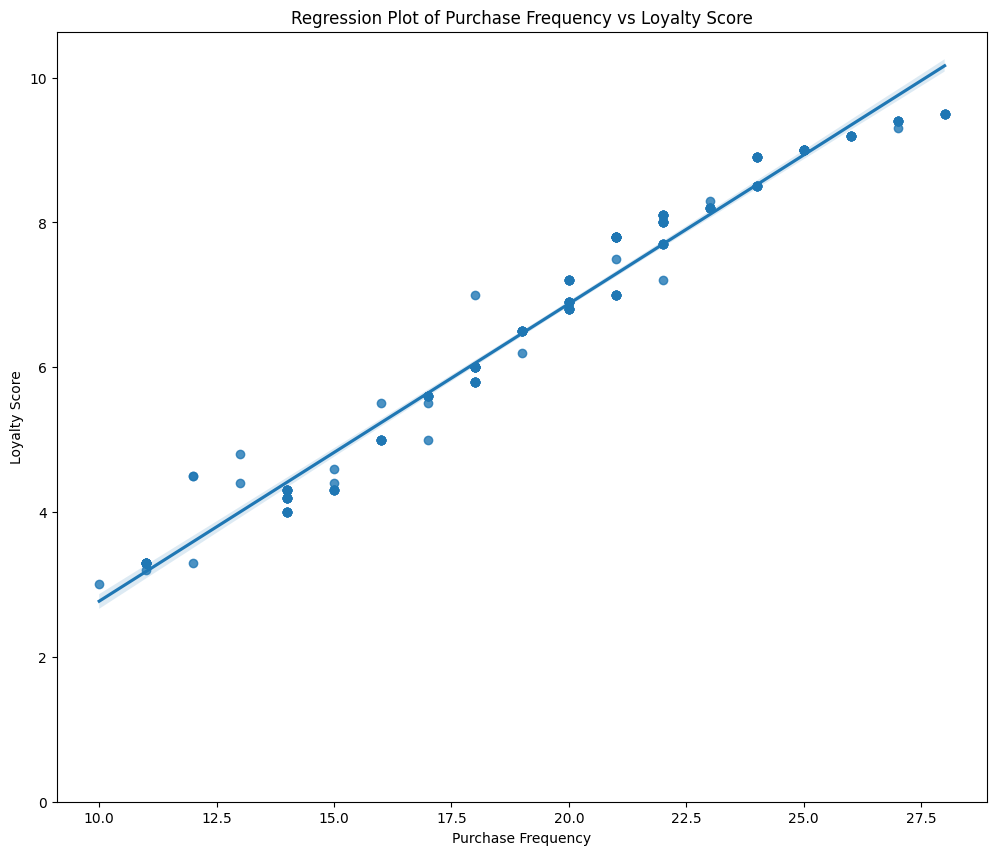

In [ ]:
# prompt: width = 12
# height = 10
# plt.figure(figsize=(width, height))
# # Using 'annual_income' and 'loyalty_score' which are in the final 'df' of the provided code
# sns.regplot(x="annual_income", y="loyalty_score", data=df) # Used the correct alias 'sns'
# plt.ylim(0,)
# plt.title('Regression Plot of Annual Income vs Loyalty Score')
# plt.xlabel('Annual Income')
# plt.ylabel('Loyalty Score')
# plt.show()
# lakukan dengan variable dependent yang lain

width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(x="purchase_amount", y="loyalty_score", data=df)
plt.ylim(0,)
plt.title('Regression Plot of Purchase Amount vs Loyalty Score')
plt.xlabel('Purchase Amount')
plt.ylabel('Loyalty Score')
plt.show()

plt.figure(figsize=(width, height))
sns.regplot(x="purchase_frequency", y="loyalty_score", data=df)
plt.ylim(0,)
plt.title('Regression Plot of Purchase Frequency vs Loyalty Score')
plt.xlabel('Purchase Frequency')
plt.ylabel('Loyalty Score')
plt.show()

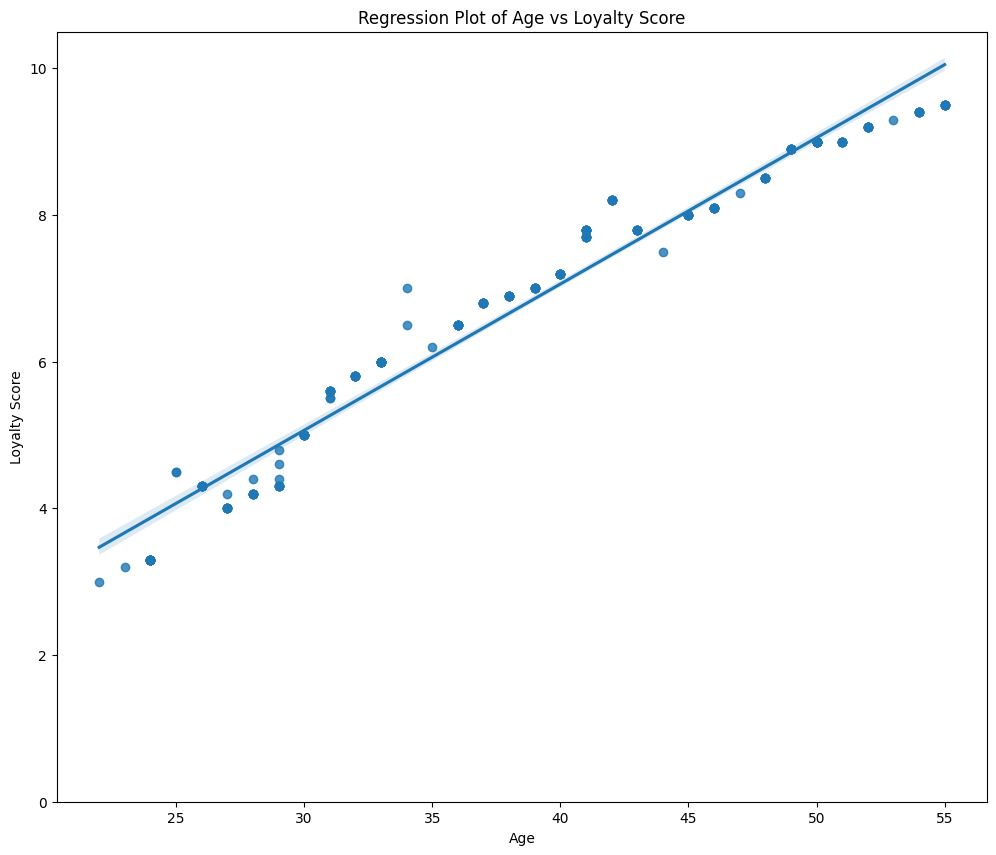

In [ ]:
# prompt: width = 12
# height = 10
# plt.figure(figsize=(width, height))
# # Using 'annual_income' and 'loyalty_score' which are in the final 'df' of the provided code
# sns.regplot(x="annual_income", y="loyalty_score", data=df) # Used the correct alias 'sns'
# plt.ylim(0,)
# plt.title('Regression Plot of Annual Income vs Loyalty Score')
# plt.xlabel('Annual Income')
# plt.ylabel('Loyalty Score')
# plt.show()
# lakukan dengan variable dependent yang lain

width = 12
height = 10

plt.figure(figsize=(width, height))
sns.regplot(x="age", y="loyalty_score", data=df)
plt.ylim(0,)
plt.title('Regression Plot of Age vs Loyalty Score')
plt.xlabel('Age')
plt.ylabel('Loyalty Score')
plt.show()

In [ ]:
# prompt: splitt = np.random.rand(len(df)) < 0.8
# train = df[splitt]
# test = df[~splitt]
# cocokkan dengan data saya

# Split data into training and testing sets
splitt = np.random.rand(len(df)) < 0.8
train = df[splitt]
test = df[~splitt]

print("Training data shape:", train.shape)
print("Testing data shape:", test.shape)


Training data shape: (189, 6)
Testing data shape: (49, 6)


In [ ]:
# prompt: lr = LinearRegression()
# train_x_simple = np.asanyarray(train[['ex_showroom_price']])
# train_y = np.asanyarray(train[['selling_price']])
# lr.fit (train_x_simple, train_y)
# print('Coefficients:',lr.coef_)
# print('Intercept:',lr.intercept_)
# print('selling_price:', lr.intercept_,'+',lr.coef_,'x','ex_showroom_price')
# cocokkan dengan data syntax saya

lr = LinearRegression()
train_x_simple = np.asanyarray(train[['annual_income']]) # Use a relevant feature from your dataset
train_y = np.asanyarray(train[['loyalty_score']]) # Use the target variable 'loyalty_score'
lr.fit(train_x_simple, train_y)
print('Coefficients:', lr.coef_)
print('Intercept:', lr.intercept_)
print('loyalty_score:', lr.intercept_, '+', lr.coef_, 'x', 'annual_income') # Update the printed equation


Coefficients: [[0.00016512]]
Intercept: [-2.69271524]
loyalty_score: [-2.69271524] + [[0.00016512]] x annual_income


In [ ]:
# prompt: train_x_multiple = np.asanyarray(train[["year","km_driven","ex_showroom_price"]])
# train_y = np.asanyarray(train[['selling_price']])
# lr.fit(train_x_multiple,train_y)
# print('Coefficients:',lr.coef_)
# print('Intercept:',lr.intercept_)
# cocokkan dengan syntax saya

# Use features relevant to loyalty_score from the dataset
train_x_multiple = np.asanyarray(train[["annual_income","purchase_amount","purchase_frequency"]])
train_y = np.asanyarray(train[['loyalty_score']])
lr.fit(train_x_multiple,train_y)
print('Coefficients:',lr.coef_)
print('Intercept:',lr.intercept_)


Coefficients: [[ 4.19088819e-05  1.20967161e-02 -6.19887958e-02]]
Intercept: [0.46976]


In [ ]:

lr.fit(test_x_simple,test_y)
y_hat = lr.predict(test_x_simple)

accuracy = 100 - np.mean(np.mean(np.abs((test_y-y_hat)/test_y))*100)
print('Accuracy:',round(accuracy,2),'%')
print('The R-squred is:',r2_score(test_y,y_hat))

mse = mean_squared_error(test_y,y_hat)
print('The mean square error is:',mse)

Accuracy: 94.83 %
The R-squred is: 0.9677515523159124
The mean square error is: 0.11992984136728381


In [ ]:
# --- Simple Linear Regression ---
print("\n--- Simple Linear Regression (Annual Income) ---")
lr_simple = LinearRegression() # Create a new LinearRegression instance for simple model
train_x_simple = np.asanyarray(train[['annual_income']])
train_y_simple = np.asanyarray(train[['loyalty_score']])
lr_simple.fit(train_x_simple, train_y_simple)
print('Coefficients:', lr_simple.coef_)
print('Intercept:', lr_simple.intercept_)
print('loyalty_score:', lr_simple.intercept_, '+', lr_simple.coef_, 'x', 'annual_income')

# Evaluate Simple Linear Regression model on the test set
test_x_simple = np.asanyarray(test[['annual_income']])
test_y_simple = np.asanyarray(test[['loyalty_score']])

y_hat_simple = lr_simple.predict(test_x_simple)

# Calculate Accuracy (using the percentage error approach)
# Handle potential division by zero
# Adding a small epsilon to the denominator to avoid division by zero
epsilon = 1e-8
accuracy_simple = 100 - np.mean(np.abs((test_y_simple - y_hat_simple) / (test_y_simple + epsilon))) * 100
print('Accuracy:', round(accuracy_simple, 2), '%')

# Calculate R-squared
r2_simple = r2_score(test_y_simple, y_hat_simple)
print('The R-squared is:', r2_simple)

# Calculate Mean Squared Error (MSE)
mse_simple = mean_squared_error(test_y_simple, y_hat_simple)
print('The mean square error is:', mse_simple)


--- Simple Linear Regression (Annual Income) ---
Coefficients: [[0.00016524]]
Intercept: [-2.69125147]
loyalty_score: [-2.69125147] + [[0.00016524]] x annual_income
Accuracy: 94.59 %
The R-squared is: 0.9658998098406778
The mean square error is: 0.11709729772310963


In [ ]:
# --- Multiple Linear Regression ---
print("\n--- Multiple Linear Regression ---")
lr_multiple = LinearRegression() # Create a new LinearRegression instance for multiple model
train_x_multiple = np.asanyarray(train[["annual_income","purchase_amount","purchase_frequency"]])
train_y_multiple = np.asanyarray(train[['loyalty_score']])
lr_multiple.fit(train_x_multiple,train_y_multiple)
print('Coefficients:',lr_multiple.coef_)
print('Intercept:',lr_multiple.intercept_)

# Evaluate the multiple linear regression model on the test set
test_x_multiple = np.asanyarray(test[["annual_income", "purchase_amount", "purchase_frequency"]])
test_y_multiple = np.asanyarray(test[['loyalty_score']])

y_hat_multiple = lr_multiple.predict(test_x_multiple)

# Calculate Accuracy (using the percentage error approach)
# Handle potential division by zero
accuracy_multiple = 100 - np.mean(np.abs((test_y_multiple - y_hat_multiple) / (test_y_multiple + epsilon))) * 100
print('Accuracy:', round(accuracy_multiple, 2), '%')

# Calculate R-squared
r2_multiple = r2_score(test_y_multiple, y_hat_multiple)
print('The R-squared is:', r2_multiple)

# Calculate Mean Squared Error (MSE)
mse_multiple = mean_squared_error(test_y_multiple, y_hat_multiple)
print('The mean square error is:', mse_multiple)


--- Multiple Linear Regression ---
Coefficients: [[ 3.46019680e-05  1.20593093e-02 -4.15951710e-02]]
Intercept: [0.49677578]
Accuracy: 97.58 %
The R-squared is: 0.9910992127844375
The mean square error is: 0.030564584117600276
